Đào tạo mô hình học sâu của bạn và dự đoán việc hủy (is_canceled)


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [11]:
data = pd.read_csv('./hotel.csv')

data.head(10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
6,Resort Hotel,0,0,2015,July,27,1,0,2,2,...,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,2015-07-03
7,Resort Hotel,0,9,2015,July,27,1,0,2,2,...,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,2015-07-03
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22


In [12]:
X = data.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

In [13]:
preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [14]:
# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

In [15]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(256, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation = "relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation ="sigmoid")
])

In [17]:
model.compile(
optimizer = "Adam",
loss = "binary_crossentropy",
metrics = ["binary_accuracy"],
)

In [18]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

In [19]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - binary_accuracy: 0.7405 - loss: 0.5378 - val_binary_accuracy: 0.8049 - val_loss: 0.4352
Epoch 2/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.7984 - loss: 0.4298 - val_binary_accuracy: 0.8111 - val_loss: 0.4069
Epoch 3/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.8104 - loss: 0.4074 - val_binary_accuracy: 0.8170 - val_loss: 0.3973
Epoch 4/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - binary_accuracy: 0.8120 - loss: 0.4034 - val_binary_accuracy: 0.8149 - val_loss: 0.3946
Epoch 5/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - binary_accuracy: 0.8135 - loss: 0.3975 - val_binary_accuracy: 0.8209 - val_loss: 0.3890
Epoch 6/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.8147 - loss: 0.3933 - val_binary_accuracy: 0.8202 - val_loss: 0.3866
Epoch 7/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - binary_accuracy: 0.8179 - loss: 0.3899 - val_binary_accuracy: 0.8246 - val_loss

<Axes: title={'center': 'Accuracy'}>

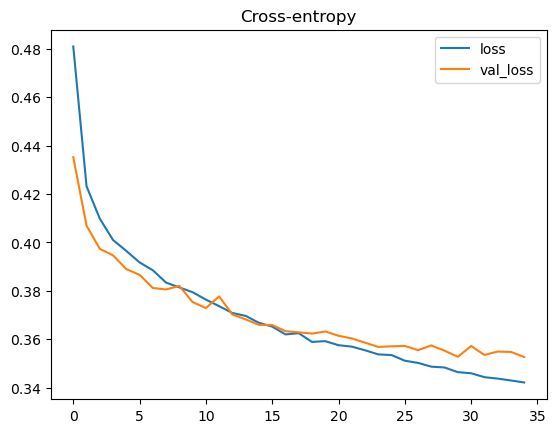

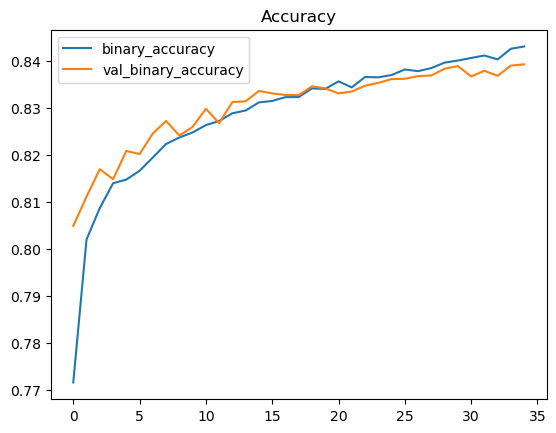

In [20]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [21]:
Y_new = model.predict(X_valid)

933/933 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
